<font size=10>
<center><b> Bank Accounts or Service Complaints </b></center>
</font>

<font size="3"> 
<br>The data comes from: https://query.data.world/s/rd2gbtkdfthsaxhlpyvpwhhv2dwsc2 
</font>

<font size="6">
<b>Importations</b>
</font>

In [32]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

<font size="6">
<b>Constants</b>
</font>

In [3]:
PATH_CSV_DATA = "Bank_Account_or_Service_Complaints.csv"

<font size="6">
<b>Private helpers</b>
</font>

In [210]:
def _plot_bar(col_data: pd.Series, number_keep: int = 15, ascending: bool = False, sort_by_index: str = False, x_label: str = None) -> None:
    """
    Plot a bar chart, where the X-Axis contains the unique values of the Series, and the Y-Axis, the number of occurrences.

    Parameters
    ----------
    col_data : pandas Series
    number_keep : int, default 15
        Limit the number of different values to consider during the plot
    ascending : bool, default False
        If False, take the most frequent `number_max` column values; otherwise, take the least frequent ones
    sort_by_index : bool, False
        If True, the figure is sorted by the values
    x_label : str
        If specified, assign it to the xlabel of the figure (axis of values)
    
    """
    # Count the values' frequency, sort them by value and keep only the requested number
    data_to_plot = col_data.value_counts(ascending=ascending)\
                           .head(number_keep)\
    
    # Sort the result by index if requested
    if sort_by_index:
        data_to_plot.sort_index(inplace=True)

    # Plot the bar
    plt.xlabel(x_label)
    plt.ylabel("Number of occurences")
    plt.bar(data_to_plot.index, data_to_plot.values[:])
    print(data_to_plot)

    return None

<font size="6">
<b>Core Analysis</b>
</font>

<font size="4">
<b>General look:</b>
</font>

In [4]:
# Load the data from the csv file into a dataframe
df_data = pd.read_csv(PATH_CSV_DATA)

# Show the dataframe
df_data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/29/2013,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,07/31/2013,Closed with explanation,Yes,No,468889
1,07/29/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065,NaN,NaN,Fax,07/31/2013,Closed,Yes,No,468879
2,07/29/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,GA,30084,NaN,NaN,Web,07/30/2013,Closed with explanation,Yes,No,468949
3,07/29/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Bank of America,TX,75025,NaN,NaN,Web,07/30/2013,Closed with explanation,Yes,No,468981
4,07/29/2013,Bank account or service,Other bank product/service,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,CA,96088,NaN,NaN,Web,08/01/2013,Closed with explanation,Yes,No,469185


<font size="4">
<b>Shape and data structure:</b>
</font>

In [200]:
# Visualize the shape, and the data type of each column
print(f"- Shape : {df_data.shape}\n")
print(f"- Data types :\n\n{df_data.dtypes}")

- Shape : (84811, 20)

- Data types :

Date received                    object
Product                          object
Sub-product                      object
Issue                            object
Sub-issue                       float64
Consumer complaint narrative     object
Company public response          object
Company                          object
State                            object
ZIP code                         object
Tags                             object
Consumer consent provided?       object
Submitted via                    object
Date sent to company             object
Company response to consumer     object
Timely response?                 object
Consumer disputed?               object
Complaint ID                      int64
Year                             object
Month                            object
dtype: object


<font size=4>
<b>Data values:</b>
</font>

<font size=3>
First, let's check if there are any missing data.
</font>

In [206]:
df_data.isna().sum()

Date received                       0
Product                             0
Sub-product                         0
Issue                               0
Sub-issue                       84811
Consumer complaint narrative    70951
Company public response         61820
Company                             0
State                            1549
ZIP code                         1550
Tags                            73179
Consumer consent provided?      62439
Submitted via                       0
Date sent to company                0
Company response to consumer        0
Timely response?                    0
Consumer disputed?               4031
Complaint ID                        0
Year                                0
Month                               0
dtype: int64

<font size=3>
<ul><li> There are many missing values : More than <b>70%</b> of the values are missing from the columns "Sub-issue", "Consumer complaint narrative", "Company public response", "Tags" and "Consumer consent provided?"<br><br>
<li> The number of missing values in the column <b>"Sub-issue"</b> equals the total number of rows. Therefore, it is an empty column. </ul> 
</font>

<font size="3"> 
Let's now take a look at the number of unique values per column.
</font>

In [7]:
df_data.nunique()

Date received                    1864
Product                             1
Sub-product                         5
Issue                               5
Sub-issue                           0
Consumer complaint narrative    13831
Company public response            10
Company                           451
State                              62
ZIP code                        15145
Tags                                3
Consumer consent provided?          4
Submitted via                       6
Date sent to company             1712
Company response to consumer        8
Timely response?                    2
Consumer disputed?                  2
Complaint ID                    84811
dtype: int64

<font size="3">
<ul><li>The column <b>"Product"</b> has a unique value, which makes it irrelevant to study. <br><br>
<li>There is 0 value in the column <b>"Sub-issue"</b>, which confirms that it is empty. <br><br>
<li>There is one different <b>"Complaint ID"</b> for each row. It is normal because it is a specific ID.</ul>
</font>

<font size=4>
<b>Complaints per state:</b>
</font>

CA    11936
FL     7759
NY     7484
TX     5100
NJ     4006
      ...  
MP        5
MH        3
FM        3
AA        2
PW        1
Name: State, Length: 62, dtype: int64


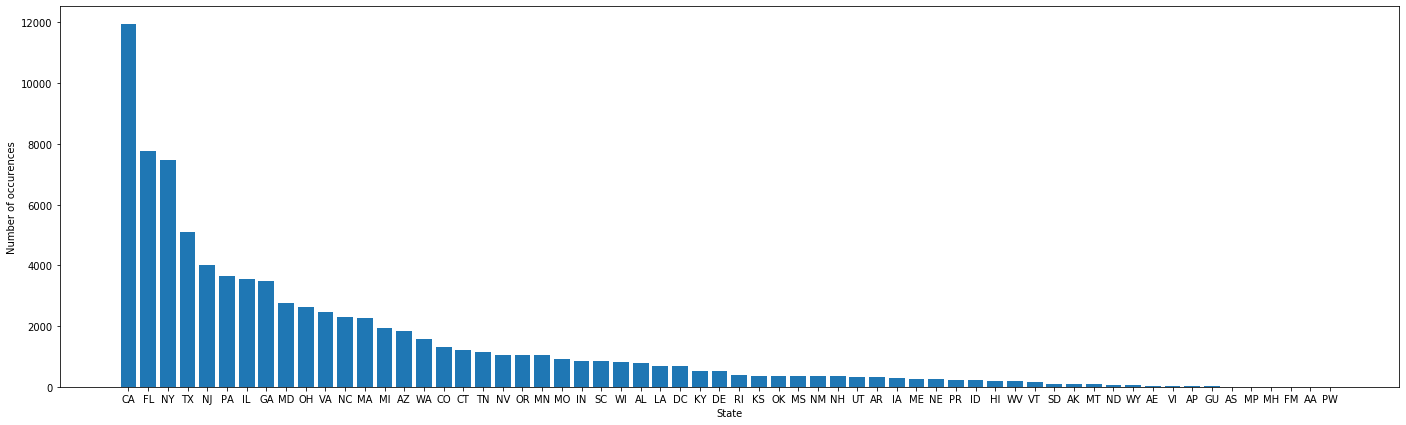

In [211]:
plt.figure(figsize=(24,7))
_plot_bar(df_data["State"], number_keep=100, x_label="State")

<font size="3">
The number of complaints is very different from a state to another : 
<ul><li>The Biggest number of complaints happens to be in California. It is almost 12 000, which corresponds to<b> 14 % </b>of the total number.<br><br>
<li>There are almost no complaints (less than 50) in 15 states like Alaska.</ul>
</font>

<font size=4>
<b>Complaints per company:</b>
</font>

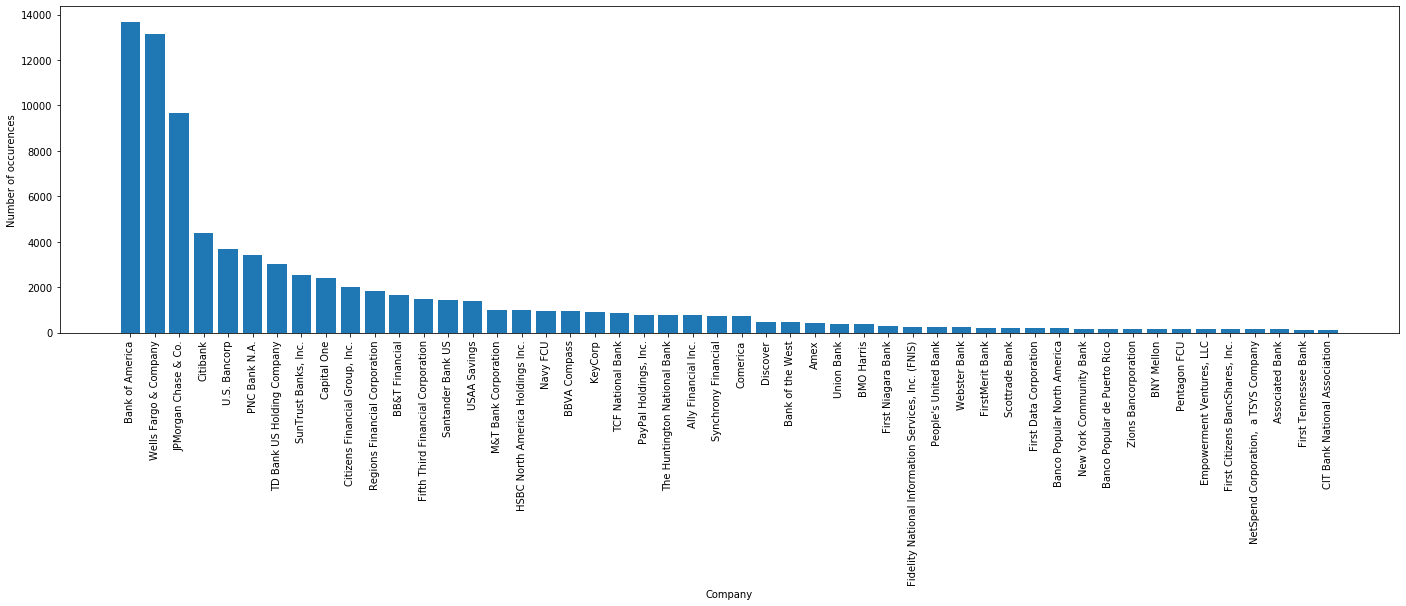

In [205]:
plt.figure(figsize=(24,6))
plt.xticks(rotation=90)
_plot_bar(df_data["Company"], number_keep=50, col_label="Company")

<font size=4>
<b>Complaints per Month/Year:</b>
</font>

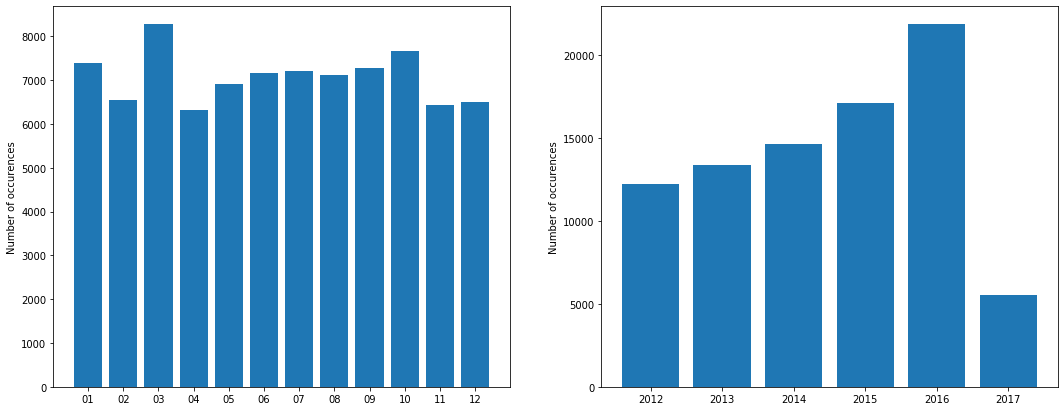

In [198]:
# Add two columns : Year and Month 
df_date_received = df_data["Date received"].str.split("/", expand=True)

df_data["Month"] = df_date_received[0]
df_data["Year"] = df_date_received[2]

# Create a figure
fig = plt.figure(figsize=(18,7))

# Add the 'Month' bar as a first subplot
ax1 = fig.add_subplot(1,2,1)
_plot_bar(df_data["Month"], sort_by_index=True)

# Add the 'Year' bar as a second subplot
ax2 = fig.add_subplot(1,2,2)
_plot_bar(df_data["Year"], sort_by_index=True)

<font size="3"> ==> The column <b>"Product"</b> has always the same value. </font>